# Assignment 2: Function Approximation for Q Learning

Name: Xiangyuan Ren

ID: A53249047

### 1. Cartpole

A cartpole problem is shown below.
![pendulum2.png](pendulum2.png)

The equation for the cartpole problem is nonlinear in nature, but it has been shown through robust control theory that a linear version of the equation of the form $\dot{x} = Ax+Bu$ can be solved by a linear controller. Let us assume that we are interested in minimizing cart stray from the center, and pendulum falling. It turns out that typical techniques - open loop control, PID control, root locus, etc. is not suitable for stabilizing both the cart position (keep near center) or the pole angle (keep vertical). The solution to this question is a linear quadratic controller, but we won't be using the solution at the moment.

### Setup Environment for Function Approximation


In [1]:
%matplotlib inline

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt

# Create the CartPole game environment
env = gym.make('CartPole-v0')
env = env.unwrapped
env.reset()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


array([ 0.01651899,  0.020169  ,  0.03030382,  0.0064973 ])

#### Demonstrate your understanding of the simulation
For OpenAI's CartPole-v0 environment,
- describe the reward system
- describe the each state variable (observation space)
- describe the action space

Ans: 1. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.
     2. The state variable is [position of cart, velocity of cart, angle of pole, rotation rate of pole]
     3. action space is a force of +1 or -1 to the cart



### Write a Deep Neural Network class that creates a dense network of a desired architecture
In this problem we will create neural network that is our function that takes states to q-values: $q=f(x)$. While any function approximator could be used (i.e. Chebyshev functions, taylor series polynomials), neural networks offer a most general form of 1st-order smooth function (though comprising of trivial small activation functions means that complex functions require a significant amount of weights to identify). 

Create a class for a QNetwork that uses PyTorch to create a fully connected sequential neural network, of the following properties:
- solver: Adam

- input and hidden layer activation function: tanh

- output activation function: linear

- loss: mse

- learning_rate: variable

- decay_rate: variable

- hidden_state sizes: variable

- state and action sizes: variable


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T

In [4]:
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

In [5]:
from IPython import display

In [6]:
class Net(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(Net, self).__init__()
        nn.Module.__init__(self)
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        #x = F.relu(self.fc1(x))
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

class QNetwork(object):#!!!!alpha decay
    def __init__(self,learning_rate, state_size, action_size, hidden_size, alpha_decay):
        self.qnet = Net(state_size, action_size, hidden_size)
        self.optimizer = torch.optim.Adam(self.qnet.parameters(), lr=learning_rate)    # torch 的优化器
        self.loss_func = nn.MSELoss()   # 误差公式
    def optimize_model(self,batch):
        x=Variable(torch.FloatTensor(batch[0]))
        y=Variable(torch.FloatTensor(batch[1]))
        a=Variable(torch.FloatTensor(batch[2]))
        output = torch.sum(DQN.qnet(x)*a,1)
        loss = self.loss_func(output, y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

#### Write a Replay class that includes all the functionality of a replay buffer
The replay buffer should kept to some maximum size (10000), allow adding of samples and returning of samples at random from the buffer. Each sample (or experience) is formed as (state, action, reward, next_state, done). The replay buffer should also be able to generate a minibatch. The generate_minibatch method should take in DQN, targetDQN, selected batch_size, and return the states present in the minibatch and the target Q values for those states.

In [7]:
class Replay():
# Replay should also have an initialize method which creates a minimum buffer for 
# the initial episodes to generate minibatches.        
    def __init__(self, max_size=10000):
        self.max_size = max_size
        self.memory = []
        self.position = 0
    def initialize(self,init_length=1000, envir=env):
        for iters in range(init_length):
            done = False
            envir.reset()
            state= envir.state#.env.state
            while not(done):
                action=env.action_space.sample()
                next_state, reward, done, info = envir.step(action)
                if done:
                    next_state=None
                self.memory.append((state,action,reward,next_state,done))
                if len(self.memory)>=self.max_size:
                    return
                state = next_state       
    def push(self,state,action,reward,next_state,done):
        """Saves a transition."""
        #if len(self.memory) < self.max_size:
        #    self.memory.append(None)
        self.memory[self.position] = (state,action,reward,next_state,done)
        self.position = (self.position + 1) % self.max_size
    def generate_minibatch (self, DQN, targetDQN, batch_size):
        tmp = random.sample(self.memory, batch_size)
        states = np.zeros((batch_size,4))
        qvalues= np.zeros(batch_size)
        actions= np.zeros((batch_size,2))
        j = 0
        for i in tmp:
            
            s1= i[0]; s2=i[3]; r = i[2]; a=i[1]
            #|print(s1,s2,r,a)
            if type(s2)==type(None):
                qvalue = r
            else:
                r1,r2 = targetDQN.qnet.forward(Variable(torch.FloatTensor(s2))).data
                #print([r1,r2])
                qvalue= r + gamma * np.max([r1,r2]) #- DQN.qnet.forward(Variable(torch.FloatTensor(s1))).data[i[1]]
            states[j,:]=s1
            qvalues[j]=qvalue; actions[j,a]=1
            j+=1
        return states,qvalues,actions
    def __len__(self):
        return len(self.memory)  

Write a function that creates a minibatch from a buffer

### Perform Function Approximation
Initialize DQN networks and Replay objects

In [8]:
# Initialize DQN

# Play around with your learning rate, alpha decay and hidden layer units 
# Two layers with a small number of units should be enough
learning_rate, state_size, action_size, hidden_size, alpha_decay = 1e-3, 4, 2, 10,0.99
DQN = QNetwork(learning_rate, state_size, action_size, hidden_size, alpha_decay)
targetDQN = QNetwork(learning_rate, state_size, action_size, hidden_size, alpha_decay)
targetDQN.qnet.load_state_dict(DQN.qnet.state_dict())
# set targetDQN weights to DQN weights
# for ex. targetDQN.model.weights = DQN.model.weights (syntax given here is for representation purpose only)

## Initialize Replay Buffer
###################################
## Populate the initial experience buffer
###################################

replay = Replay(max_size=10000)
replay.initialize(init_length=1000, envir=env)

#### Create a function that solves the above environment using a deep Q network that uses a minibatch strategy.
Use the following parameters (these had to be derived empirically - there is generally no trusted way of choosing the right parameter values - i.e. gamma, number of episodes, decay rate, min_epsilon). 

Generate a graph of the average return per episode every 100 episodes.

In [33]:
def select_action(state,epsilon):
    sample = random.random()
    eps_threshold = epsilon
    if sample > eps_threshold:
        tmp=Variable(torch.FloatTensor(state), volatile=True).type(torch.FloatTensor)
        return np.argmax(DQN.qnet(tmp).data)
    else:
        return np.random.choice([0,1])

In [47]:

# Runtime parameters

gamma = 0.99                  # future reward discount
# Exploration parameters
min_epsilon = 0.01             # minimum exploration probability

hidden_size=20
TARGET_UPDATE = 10
batch_size = 32
num_episodes = 2000
decay_rate = 5/num_episodes    # exponential decay rate for exploration prob
max_steps = 220                # cut off simulation after this many steps
state_size, action_size=4,2

returns = np.zeros(num_episodes)
for ep in range(1, num_episodes):
    #print("ep:",ep)
    epsilon = min_epsilon + (1.0 - min_epsilon)*np.exp(-decay_rate*ep)
    
    env.reset()
    state = env.state
    total_reward=0
    #print("\tt starts")
    if ep>400 and returns[-1]>180:
        mode=True
    else:
        mode=False
    for t in range(max_steps):# --> start episode 
        #print("\tt:",t)
        action = select_action(state,epsilon)# explore/exploit and get action using DQN
        next_state, reward, done, _ = env.step(action)# perform action and record new_state, action, reward
        if done:
            next_state = None
        replay.push(state,action,reward,next_state,done)# populate Replay experience buffer
        state = next_state
        total_reward+=reward
        if not(mode):
            batch = replay.generate_minibatch(DQN, targetDQN, batch_size)
            DQN.optimize_model(batch)
            if (t%TARGET_UPDATE==0):
                targetDQN.qnet.load_state_dict(DQN.qnet.state_dict())
        if done:
            break
    # <-- end episode
    #print("\tt ends")
    if ep%25==0:
        print(ep,' ',total_reward)
    returns[ep] = total_reward
    
    # Replay
    if mode:
        batch = replay.generate_minibatch(DQN, targetDQN, batch_size)
        DQN.optimize_model(batch)   
        if ep % TARGET_UPDATE == 0:
            targetDQN.qnet.load_state_dict(DQN.qnet.state_dict())
    
    
    # set targetDQN weights to DQN weights
    # update DQN (run one epoch of training per episode with generated minibatch of states and qvalues)
    
#     total_reward=0
#     state = env.reset()
#     for t in range(max_steps):# --> start episode 
#         #print("\tt:",t)
#         action = select_action(state,0)# explore/exploit and get action using DQN
#         next_state, reward, done, _ = env.step(action)# perform action and record new_state, action, reward
#         #replay.push(state,action,reward,next_state,done)# populate Replay experience buffer
#         state = next_state
#         total_reward+=reward
#         #batch = replay.generate_minibatch(DQN, targetDQN, batch_size)
#         #targetDQN.qnet.load_state_dict(DQN.qnet.state_dict())
#         if done:
#             break  
#     returns[ep]=total_reward

25   20.0
50   13.0
75   38.0
100   16.0
125   49.0
150   137.0
175   94.0
200   20.0
225   129.0
250   44.0
275   140.0
300   220.0
325   141.0
350   220.0
375   123.0
400   188.0
425   119.0
450   27.0
475   220.0
500   220.0
525   220.0
550   116.0
575   34.0
600   220.0
625   71.0
650   220.0
675   220.0
700   19.0
725   220.0
750   10.0
775   161.0
800   220.0
825   140.0
850   149.0
875   119.0
900   109.0
925   220.0
950   220.0
975   220.0
1000   220.0
1025   220.0
1050   46.0
1075   220.0
1100   220.0
1125   220.0
1150   12.0
1175   220.0
1200   170.0
1225   220.0
1250   220.0
1275   102.0
1300   220.0
1325   146.0
1350   148.0
1375   220.0
1400   220.0
1425   10.0
1450   219.0
1475   220.0
1500   40.0
1525   38.0
1550   220.0
1575   220.0
1600   150.0
1625   220.0
1650   220.0
1675   12.0
1700   220.0
1725   220.0
1750   220.0
1775   220.0
1800   220.0
1825   220.0
1850   220.0
1875   220.0
1900   220.0
1925   220.0
1950   220.0
1975   220.0


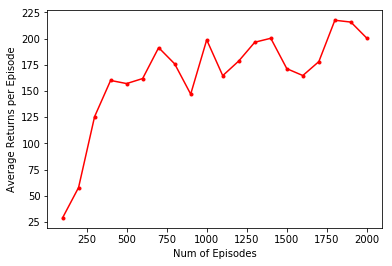

In [48]:
# plot average returns
returns_over_100_episodes = []
x = []
for i in range(0,int(num_episodes/100)):
    returns_over_100_episodes.append(sum(returns[100*i:100*(i+1)-1])/100)
    x.append((i+1)*100)
plt.plot(x,returns_over_100_episodes,'.-r')
plt.ylabel('Average Returns per Episode')
plt.xlabel('Num of Episodes')
plt.show()

In [49]:
# DEMO FINAL NETWORK
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())
state = np.reshape(state, [1, state.size])
total_reward = 0
for i in range(0, max_steps):
    env.render()
    
    # Get action from Q-network
    tmp=Variable(torch.FloatTensor(state), volatile=True).type(torch.FloatTensor)
    Qs =DQN.qnet(tmp).data
    # Qs = output of DQN.model when state is passed in
    action = np.argmax(Qs)
    
    # Take action, get new state and reward
    next_state, reward, done, _ = env.step(action)
    total_reward += reward

    if done:
        break
    else:
        state = np.reshape(next_state, [1, state.size])